In [1]:
import numpy as np
import pandas as pd
import optuna
from sklearn.metrics import f1_score
from  sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, \
    RandomizedSearchCV, cross_val_score
from hyperopt import hp, fmin, tpe, Trials

# 1. Интро
## 1.0 Кастомизация

In [2]:
def on_da_screen(model)->float:
    """
    Принимает на вход обученную модель. Рассчитывает и отображает F-меру тестовой выборки,
    параметры переданной модели.

    Params:    model: обученная модель

    Returns:   F-мера тестовой выборки
    """
    try:
        print(f'Лучшая комбинация:\n {model.best_params_}\n')
    except: pass
    y_test_pred = model.predict(X_test)
    f_score = f1_score(y_test, y_test_pred)
    print(f'F1-мера на тестовой части: {round(f_score, 3)}')
    return f_score

## 1.1 Подгрузка данных

In [3]:
df = pd.read_csv('Data/_train_sem09.csv')
data = df.copy()
display(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3751 entries, 0 to 3750
Columns: 1777 entries, Activity to D1776
dtypes: float64(942), int64(835)
memory usage: 50.9 MB


None

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


## 1.2 Предобработка
Сделана.

# 2. Построение моделей
Перед построением моделей разобъём датасет на тестовую и тренировочную части.

1    0.542255
0    0.457745
Name: Activity, dtype: float64

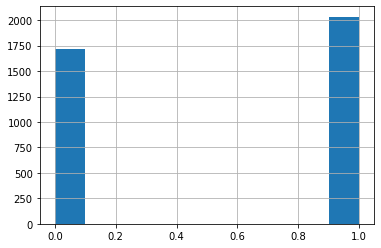

In [4]:
X = data.drop(columns='Activity')
y = data['Activity']
# оценим сбалансированность целевой переменной
y.hist()
y.value_counts(normalize=True)

Разница приемлемая -- обойдёмся без стратификации.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,
                                                    test_size=0.2)

## 2.1 Логистическая регрессия
### 2.1.1 Базовая модель

In [6]:
lr = LogisticRegression(max_iter=5000)
lr.fit(X_train, y_train)
pred_y_test_base = lr.predict(X_test)
f1_score_base_lg = on_da_screen(lr)

F1-мера на тестовой части: 0.789


### 2.1.2 Grid search
Так как данные уже нормализованны, будем использовать алгоритмы реализующие такую предобработку данных: sag, saga и дополнительно lbfgs.

In [7]:
# Параметры поиска
param_grid_lr = [{'penalty': ['l1', 'l2', 'none'],
                  'solver': ['saga'],
                  'C': [0.01, 0.5, 1]},
                 {'penalty': ['elasticnet'],
                  'solver': ['saga'],
                  'C': [0.01, 0.5, 1],
                  'l1_ratio': [0.25, 0.5, 0.75]},
                 {'penalty': ['l2', 'none'],
                  'solver': ['lbfgs', 'sag'],
                  'C': [0.01, 0.5, 1]}]
# Cоздаём объект класса
grid_search_lr = GridSearchCV(estimator=LogisticRegression(max_iter = 2000,
                                                           random_state=42),
                              param_grid=param_grid_lr,
                              scoring='f1',
                              n_jobs=-1)
%time grid_search_lr.fit(X_train, y_train)
f1_score_search_grid_lr = on_da_screen(grid_search_lr)

CPU times: total: 1min 3s
Wall time: 10min 56s
Лучшая комбинация:
 {'C': 0.5, 'penalty': 'l1', 'solver': 'saga'}

F1-мера на тестовой части: 0.797


### 2.1.3 Random search
Так как этот метод выполняется быстрее чем grid search, расширим набор параметров С и l1_ratio.

In [8]:
C = list(np.linspace(0.01, 1, 11))
param_rand = [{'penalty': ['l1', 'l2', 'none'],
               'solver': ['saga'],
               'C': C},
              {'penalty': ['elasticnet'],
               'solver': ['saga'],
               'C': C,
               'l1_ratio': list(np.linspace(0.1, 0.9, 9))},
              {'penalty': ['l2', 'none'],
               'solver': ['lbfgs', 'sag'],
               'C': C}]
rand_search_lr = RandomizedSearchCV(
    estimator=LogisticRegression(max_iter=2000, random_state=42),
    param_distributions=param_rand,
    scoring='f1',
    n_jobs=-1,
    random_state=42
)
%time rand_search_lr.fit(X_train, y_train)
f1_score_rand_search_lr = on_da_screen(rand_search_lr)

CPU times: total: 14.3 s
Wall time: 4min
Лучшая комбинация:
 {'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': 0.4, 'C': 0.109}

F1-мера на тестовой части: 0.8


### 2.1.4 Hyperopt

In [9]:
def hyperopt_lr(params)->float:
    """
    Функция для минимизации в библиотеке hyperopt. Принимает гиперпараметры
    модели. Рассчитывает F-меру, используя кроссвалидацию по умолчанию(kf=5)
    , и возвращает её со знаком минус, так мы ищем наименьшее значение.

     Params:
            params: Набор гиперпараметров модели, передаваемый из функции
                    fmin()

     Return:
            F-мера со знаком минус
    """

    # проверка параметров на совместимость:
    sag_and_lbfgs_penalty = ['l2', 'none']
    if params['solver'] == 'sag' or params['solver'] == 'lbfgs':
        if params['penalty'] in sag_and_lbfgs_penalty:
            del params['l1_ratio']
        else: return 0
    else:
        if params['penalty'] != 'elasticnet':
            del params['l1_ratio']

    if params['penalty'] == 'none':
        del params['C']

    model = LogisticRegression(**params, max_iter=5000, random_state=42)
    score = cross_val_score(model, X_train, y_train, scoring="f1",
                            n_jobs=-1).mean()
    # метрику необходимо минимизировать
    return -score


trials_lr = Trials() # логирования результатов
penalty = ['l1', 'l2', 'elasticnet', 'none']
solver = ['sag', 'saga', 'lbfgs']
space_lr = {
    'penalty': hp.choice('penalty', penalty),
    'solver': hp.choice('solver', solver),
    'C': hp.uniform('C', 0.01, 1),
    'l1_ratio': hp.uniform('l1_ratio', 0.1, 0.9)
}
best_lr_hyperopt = fmin(hyperopt_lr,
                        space=space_lr,
                        algo=tpe.suggest,
                        max_evals=20,
                        trials=trials_lr,
                        rstate=np.random.RandomState(42)
                        )
print("Наилучшие значения гиперпараметров {}".format(best_lr_hyperopt))
# заменяем индексы на их значения в соответствующих списках
best_lr_hyperopt['penalty'] = penalty[best_lr_hyperopt['penalty']]
best_lr_hyperopt['solver'] = solver[best_lr_hyperopt['solver']]
# модель с полученными гиперпараметрами
hyperopt_lr_best = LogisticRegression(**best_lr_hyperopt, max_iter=5000,
                                      random_state=42)
hyperopt_lr_best.fit(X_train, y_train)
# метрика на тестовых данных
f1_score_hyperopt_lr = on_da_screen(hyperopt_lr_best)

100%|██████████| 20/20 [08:50<00:00, 26.54s/trial, best loss: -0.7827501176724684]
Наилучшие значения гиперпараметров {'C': 0.11381056696717652, 'l1_ratio': 0.8349780173355015, 'penalty': 1, 'solver': 0}


C:\Users\gosta\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


F1-мера на тестовой части: 0.795


+20

In [10]:
best_lr_hyperopt_extra = fmin(hyperopt_lr,
                        space=space_lr,
                        algo=tpe.suggest,
                        max_evals=40,
                        trials=trials_lr,
                        rstate=np.random.RandomState(42)
                        )
print("Наилучшие значения гиперпараметров {}".format(best_lr_hyperopt_extra))
# заменяем индексы на их значения в соответствующих списках
best_lr_hyperopt_extra['penalty'] = penalty[best_lr_hyperopt_extra['penalty']]
best_lr_hyperopt_extra['solver'] = solver[best_lr_hyperopt_extra['solver']]
# модель с полученными гиперпараметрами
hyperopt_lr_best_extra = LogisticRegression(**best_lr_hyperopt_extra,
                                            max_iter=5000,
                                            random_state=42)
hyperopt_lr_best_extra.fit(X_train, y_train)
# метрика на тестовых данных
f1_score_hyperopt_lr_extra = on_da_screen(hyperopt_lr_best_extra)

100%|██████████| 40/40 [10:03<00:00, 30.17s/trial, best loss: -0.7864384716009365]
Наилучшие значения гиперпараметров {'C': 0.045017900498050614, 'l1_ratio': 0.3192001651038195, 'penalty': 1, 'solver': 1}


C:\Users\gosta\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


F1-мера на тестовой части: 0.795


Немного поднялась метрика тренировочно части, но на тестовой - это никак не отразилось.

### 2.1.5 Optuna

In [11]:
def optuna_lr(trial)->float:
    """
    Задаёт пространство гиперпараметров и обучает модель.
    Возвращает F-меру модели на обучающей выборке. Нежизнеспособным
    комбинациям присваивается нулевое значение.
    """
    solver_opt = trial.suggest_categorical('solver', ['sag', 'saga', 'lbfgs'])
    c_opt = trial.suggest_float('C', 0.01, 0.96, step=0.05)
    penalty_opt = trial.suggest_categorical(
            'penalty', ['l1', 'l2', 'elasticnet', 'none']
    )
    l1_ratio_opt = trial.suggest_float('l1_ratio', 0.05, 0.95, step=0.05)
    try:
        model_opt = LogisticRegression(max_iter=5000,
                                       random_state=42,
                                       solver=solver_opt,
                                       C=c_opt,
                                       penalty=penalty_opt,
                                       l1_ratio=l1_ratio_opt)
        model_opt.fit(X_train, y_train)
        score = cross_val_score(model_opt, X_train, y_train, scoring="f1",
                                n_jobs=-1).mean()
    except ValueError:
        score = 0
    return score


# Ищем лучшую комбинацию гиперпараметров при максимизации метрики:
study = optuna.create_study(study_name='Test run', direction="maximize")
study.optimize(optuna_lr, n_trials=20)
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))
# модель с полученными гиперпараметрами
optuna_lr_best = LogisticRegression(**study.best_params, max_iter=5000,
                                    random_state=42)
optuna_lr_best.fit(X_train, y_train)
# метрика на тестовых данных
f1_score_optuna_lr = on_da_screen(optuna_lr_best)

[I 2022-08-19 22:04:46,537] A new study created in memory with name: Test run
[I 2022-08-19 22:04:46,538] Trial 0 finished with value: 0.0 and parameters: {'solver': 'sag', 'C': 0.66, 'penalty': 'elasticnet', 'l1_ratio': 0.6000000000000001}. Best is trial 0 with value: 0.0.
[I 2022-08-19 22:04:46,539] Trial 1 finished with value: 0.0 and parameters: {'solver': 'sag', 'C': 0.060000000000000005, 'penalty': 'elasticnet', 'l1_ratio': 0.7500000000000001}. Best is trial 0 with value: 0.0.
C:\Users\gosta\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
[I 2022-08-19 22:07:50,084] Trial 2 finished with value: 0.7805583718514042 and parameters: {'solver': 'saga', 'C': 0.91, 'penalty': 'l1', 'l1_ratio': 0.6500000000000001}. Best is trial 2 with value: 0.7805583718514042.
C:\Users\gosta\AppData\Local\Programs\Python\Python39\lib\site-packages

Наилучшие значения гиперпараметров {'solver': 'saga', 'C': 0.81, 'penalty': 'l1', 'l1_ratio': 0.25}
f1_score на обучающем наборе: 0.78
F1-мера на тестовой части: 0.789


Модель с полученными параметрами показывает результат схожий с базовым. Попробуем улучшить его, для этого поднимем к-во итераций до 40.

In [12]:
study.optimize(optuna_lr, n_trials=20)
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))
# модель с полученными гиперпараметрами
optuna_lr_best_extra = LogisticRegression(**study.best_params, max_iter=5000,
                                          random_state=42)
optuna_lr_best_extra.fit(X_train, y_train)
# метрика на тестовых данных
f1_score_optuna_lr_extra = on_da_screen(optuna_lr_best_extra)

C:\Users\gosta\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
[I 2022-08-19 22:45:14,594] Trial 20 finished with value: 0.7824490517772814 and parameters: {'solver': 'saga', 'C': 0.8600000000000001, 'penalty': 'l1', 'l1_ratio': 0.4}. Best is trial 20 with value: 0.7824490517772814.
C:\Users\gosta\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
[I 2022-08-19 22:48:19,136] Trial 21 finished with value: 0.7824490517772814 and parameters: {'solver': 'saga', 'C': 0.8600000000000001, 'penalty': 'l1', 'l1_ratio': 0.4}. Best is trial 20 with value: 0.7824490517772814.
C:\Users\gosta\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1106: User

Наилучшие значения гиперпараметров {'solver': 'saga', 'C': 0.8600000000000001, 'penalty': 'l1', 'l1_ratio': 0.4}
f1_score на обучающем наборе: 0.78
F1-мера на тестовой части: 0.785


Хм метрика на тестовой ещё ниже чем на двадцати итерациях... Попробуем ещё +20 итераций.

In [13]:
study.optimize(optuna_lr, n_trials=20)
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))
# модель с полученными гиперпараметрами
optuna_lr_best_extra_2 = LogisticRegression(**study.best_params, max_iter=5000,
                                          random_state=42)
optuna_lr_best_extra_2.fit(X_train, y_train)
# метрика на тестовых данных
f1_score_optuna_lr_extra_2 = on_da_screen(optuna_lr_best_extra_2)

C:\Users\gosta\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
[I 2022-08-19 23:37:16,762] Trial 40 finished with value: 0.7795063371400853 and parameters: {'solver': 'saga', 'C': 0.96, 'penalty': 'l1', 'l1_ratio': 0.7000000000000001}. Best is trial 20 with value: 0.7824490517772814.
C:\Users\gosta\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
[I 2022-08-19 23:40:28,888] Trial 41 finished with value: 0.7824490517772814 and parameters: {'solver': 'saga', 'C': 0.8600000000000001, 'penalty': 'l1', 'l1_ratio': 0.5}. Best is trial 20 with value: 0.7824490517772814.
C:\Users\gosta\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1106: Use

Наилучшие значения гиперпараметров {'solver': 'saga', 'C': 0.31000000000000005, 'penalty': 'l1', 'l1_ratio': 0.35000000000000003}
f1_score на обучающем наборе: 0.78
F1-мера на тестовой части: 0.801


## 2.2 Случайный лес
### 2.2.1 Базовая модель

In [14]:
rf = RandomForestClassifier(n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)
f1_score_base_rf = on_da_screen(rf)

F1-мера на тестовой части: 0.828


### 2.2.2 Grid search

In [15]:
# пространство гиперпараметров
param_grid_rf = {'n_estimators': [100, 200, 400, 600, 800],
                 'criterion': ['gini', 'entropy', 'log_loss'],
                 'max_depth': [2, 4, 6],
                 'min_samples_leaf': [5, 10, 15]}
grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1,
                                                               random_state=42),
                              param_grid=param_grid_rf,
                              scoring='f1',
                              n_jobs=-1)
grid_search_rf.fit(X_train, y_train)
f1_score_search_grid_rf = on_da_screen(grid_search_rf)

Лучшая комбинация:
 {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 5, 'n_estimators': 600}

F1-мера на тестовой части: 0.798


### 2.2.3 Random search

In [16]:
param_rand_rf = {'n_estimators': [100, 200, 400, 800, 1600],
                 'criterion': ['gini', 'entropy', 'log_loss'],
                 'max_depth': list(range(6, 42, 2)),
                 'min_samples_leaf': list(range(1, 16))}
rand_search_rf = RandomizedSearchCV(
    estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
    param_distributions=param_rand_rf,
    scoring='f1',
    n_jobs=-1,
    random_state=42
)
%time rand_search_rf.fit(X_train, y_train)
f1_score_rand_search_rf = on_da_screen(rand_search_rf)

CPU times: total: 19.3 s
Wall time: 39.3 s
Лучшая комбинация:
 {'n_estimators': 1600, 'min_samples_leaf': 5, 'max_depth': 18, 'criterion': 'log_loss'}

F1-мера на тестовой части: 0.839


### 2.2.4 Hyperopt

In [17]:
def hyperopt_rf(params)->float:
    """
    Функция для минимизации в библиотеке hyperopt. Принимает гиперпараметры
    модели. Рассчитывает F-меру, используя кроссвалидацию по умолчанию(kf=5)
    , и возвращает её со знаком минус, так мы ищем наименьшее значение.

     Params:
            params: Набор гиперпараметров модели, передаваемый из функции
                    fmin()

     Return:
            F-мера со знаком минус
    """
    params = {'n_estimators': int(params['n_estimators']),
              'max_depth': int(params['max_depth']),
              'min_samples_leaf': int(params['min_samples_leaf']),
              'criterion': params['criterion']}
    model = RandomForestClassifier(**params, n_jobs=-1, random_state=42)
    score = cross_val_score(model, X_train, y_train, scoring="f1",
                            n_jobs=-1).mean()
    # метрику необходимо минимизировать
    return -score


trials_rf = Trials() # логирования результатов
criterion = ['gini', 'entropy', 'log_loss']
space_rf = {'n_estimators': hp.quniform('n_estimators', 100, 2000, 50),
            'max_depth' : hp.quniform('max_depth', 6, 40, 1),
            'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 15, 1),
            'criterion': hp.choice('criterion', criterion)}
best_rf_hyperopt = fmin(hyperopt_rf,
                        space=space_rf,
                        algo=tpe.suggest,
                        max_evals=20,
                        trials=trials_rf,
                        rstate=np.random.RandomState(42)
                        )
print("Наилучшие значения гиперпараметров {}".format(best_rf_hyperopt))
best_rf_hyperopt = {x: int(best_rf_hyperopt[x]) for x in best_rf_hyperopt
    .keys()}
# заменяем индекс на его значение
best_rf_hyperopt['criterion'] = criterion[best_rf_hyperopt['criterion']]
# модель с полученными гиперпараметрами
hyperopt_rf_best = RandomForestClassifier(**best_rf_hyperopt, n_jobs=-1,
                                          random_state=42)
hyperopt_rf_best.fit(X_train, y_train)
# метрика на тестовых данных
f1_score_hyperopt_rf = on_da_screen(hyperopt_rf_best)

100%|██████████| 20/20 [02:11<00:00,  6.59s/trial, best loss: -0.8091294972610672]
Наилучшие значения гиперпараметров {'criterion': 2, 'max_depth': 35.0, 'min_samples_leaf': 1.0, 'n_estimators': 1100.0}
F1-мера на тестовой части: 0.832


Попробуем улучшить, для этого поднимем к-во итераций до 40.

In [18]:
hyperopt_extra_rf = fmin(hyperopt_rf,
                         space=space_rf,
                         algo=tpe.suggest,
                         max_evals=40,
                         trials=trials_rf,
                         rstate=np.random.RandomState(42)
                        )
extra = {x: int(hyperopt_extra_rf[x]) for x in hyperopt_extra_rf.keys()}
# заменяем индекс на его значение
extra['criterion'] = criterion[extra['criterion']]
print("Наилучшие значения гиперпараметров {}".format(extra))
# модель с полученными гиперпараметрами
hyperopt_rf_best = RandomForestClassifier(**extra, n_jobs=-1,
                                          random_state=42)
hyperopt_rf_best.fit(X_train, y_train)
# метрика на тестовых данных
f1_score_hyperopt_rf_extra = on_da_screen(hyperopt_rf_best)

100%|██████████| 40/40 [00:59<00:00,  2.96s/trial, best loss: -0.8139521366663125]
Наилучшие значения гиперпараметров {'criterion': 'gini', 'max_depth': 28, 'min_samples_leaf': 1, 'n_estimators': 250}
F1-мера на тестовой части: 0.834


до 60

In [19]:
hyperopt_extra_rf = fmin(hyperopt_rf,
                         space=space_rf,
                         algo=tpe.suggest,
                         max_evals=40,
                         trials=trials_rf,
                         rstate=np.random.RandomState(42)
                        )
extra = {x: int(hyperopt_extra_rf[x]) for x in hyperopt_extra_rf.keys()}
# заменяем индекс на его значение
extra['criterion'] = criterion[extra['criterion']]
print("Наилучшие значения гиперпараметров {}".format(extra))
# модель с полученными гиперпараметрами
hyperopt_rf_best = RandomForestClassifier(**extra, n_jobs=-1,
                                          random_state=42)
hyperopt_rf_best.fit(X_train, y_train)
# метрика на тестовых данных
f1_score_hyperopt_rf_extra_60 = on_da_screen(hyperopt_rf_best)

100%|██████████| 40/40 [00:00<?, ?trial/s, best loss=?]
Наилучшие значения гиперпараметров {'criterion': 'gini', 'max_depth': 28, 'min_samples_leaf': 1, 'n_estimators': 250}
F1-мера на тестовой части: 0.834


### 2.2.5 Optuna

In [20]:
def optuna_fr(trial)->float:
    """
    Задаёт пространство гиперпараметров и обучает модель.
    Возвращает F-меру модели на обучающей выборке.
    """
    criterion_opt = trial.suggest_categorical('criterion',
                                              ['gini', 'entropy', 'log_loss'])
    n_estimators = trial.suggest_int('n_estimators', 100, 2000, step=50)
    max_depth = trial.suggest_int('max_depth', 6, 40)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 15)
    model_opt = RandomForestClassifier(n_estimators=n_estimators,
                                       criterion=criterion_opt,
                                       max_depth=max_depth,
                                       min_samples_leaf=min_samples_leaf,
                                       n_jobs=-1,
                                       random_state=42)
    model_opt.fit(X_train, y_train)
    score = cross_val_score(model_opt, X_train, y_train, scoring="f1",
                            n_jobs=-1).mean()
    return score


# Ищем лучшую комбинацию гиперпараметров при максимизации метрики:
study = optuna.create_study(study_name='Test run', direction="maximize")
study.optimize(optuna_fr, n_trials=20)
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

[I 2022-08-20 00:26:01,979] A new study created in memory with name: Test run
[I 2022-08-20 00:26:09,405] Trial 0 finished with value: 0.8043577705264854 and parameters: {'criterion': 'log_loss', 'n_estimators': 950, 'max_depth': 28, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8043577705264854.
[I 2022-08-20 00:26:11,556] Trial 1 finished with value: 0.7864884088411424 and parameters: {'criterion': 'gini', 'n_estimators': 300, 'max_depth': 11, 'min_samples_leaf': 11}. Best is trial 0 with value: 0.8043577705264854.
[I 2022-08-20 00:26:16,641] Trial 2 finished with value: 0.7876045535922385 and parameters: {'criterion': 'log_loss', 'n_estimators': 850, 'max_depth': 31, 'min_samples_leaf': 15}. Best is trial 0 with value: 0.8043577705264854.
[I 2022-08-20 00:26:24,040] Trial 3 finished with value: 0.8046411104244784 and parameters: {'criterion': 'entropy', 'n_estimators': 950, 'max_depth': 30, 'min_samples_leaf': 4}. Best is trial 3 with value: 0.8046411104244784.
[I 2022-08-20

Наилучшие значения гиперпараметров {'criterion': 'entropy', 'n_estimators': 1650, 'max_depth': 37, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.82


In [21]:
# модель с полученными гиперпараметрами
optuna_fr_best = RandomForestClassifier(**study.best_params, n_jobs=-1,
                                    random_state=42)
optuna_fr_best.fit(X_train, y_train)
# метрика на тестовых данных
f1_score_optuna_fr = on_da_screen(optuna_fr_best)

F1-мера на тестовой части: 0.839


# Вывод
Таким образом, можно сделать следующие заключение -  для решения задач необходимо использовать различные алгоритмы, так как изначально трудно 
предположить, что сработает лучше. В данном случае наилучший результат был достигнут с помощью ансамбля случайного леса при с оптимальными гиперпараметрами от Optuna. 